In [1]:
import numpy as np

main_dir = 'project_folder/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)


## functions

### analysis functions

In [ ]:
## get seeds for permutations
import random
num_seeds = 10
random.seed(17)
seeds = [random.randint(1, 10000) for _ in range(num_seeds)]
print(seeds)

In [5]:

def get_simil_reli_indices(reli1, reli1_indices, reli2, reli2_indices, seed, verbose=False):
    """This function subsamples the indices of the first group (`reli1_indices`) 
    based on the reliability values of two groups (`reli1` and `reli2`) to ensure 
    similar reliability distributions between the two groups. The subsampling is 
    performed by selecting indices from `reli1_indices` that correspond to reliability 
    values in `reli1` that are close to the reliability values in `reli2`.

    Args:
        reli1 (numpy.ndarray): Array containing reliability values for the first group.
        reli1_indices (numpy.ndarray): Indices corresponding to the first group.
        reli2 (numpy.ndarray): Array containing reliability values for the second group.
        reli2_indices (numpy.ndarray): Indices corresponding to the second group.
        seed (int): Seed value for reproducible random sampling.

    Returns:
        numpy.ndarray: Subsampled indices from the first group.
        numpy.ndarray: Indices from the second group (unchanged).

    Raises:
        None

    """
    new_array1_indices = []
    # Extract reliability values for the first and second groups
    array1= reli1[reli1_indices]
    array2=reli2[reli2_indices]
    
    # Iterate over each reliability value in the second group
    for reli_val2 in array2:
        array1_vals = []
        # Define a tolerance for comparing reliability values
        tolerance = 0.001
        count=0
        
        # Iterate over each reliability value in the first group
        for a1, reli_val1 in enumerate(array1):
            # Check if the reliability value in the first group is close to the one in the second group
            if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                # Increment the count and add the index to the list if it meets the condition
                count =+1
                array1_vals.append(a1)  
        # If no similar reliability values are found, increase the tolerance and try again
        while count==0:
            if verbose is True:
                print(f'{tolerance} didnt work')
            tolerance *= 2
            for a1, reli_val1 in enumerate(array1):
                if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                    count =+1
                    array1_vals.append(a1)
        # Randomly select an index from the list of similar reliability values and add it to the new indices list
        np.random.seed(seed)
        new_array1_indices.append(np.random.choice(array1_vals))
    return reli1_indices[new_array1_indices], reli2_indices

In [186]:
def store_L23_indices(mouse_stats_, condition_types = ['ori32','natim32']):
    """Store indices for creating subpopulations in layer L23 based on reliability.

    This function iterates over each condition type and mouse in the provided `mouse_stats_`.
    For each mouse and condition type, it retrieves reliability and SNR values for layers L23 and L4.
    Then, it filters the indices based on a reliability threshold of 0.8 and an SNR threshold of 2.
    After filtering, it generates similar subpopulations in L23 and L4 using the `get_simil_reli_indices` function.
    Finally, it stores the generated L23 indices in the `mouse_stats_` dictionary.

    Args:
        mouse_stats_ (dict): Dictionary containing mouse statistics data.
        condition_types (list, optional): List of condition types to consider. Defaults to ['ori32', 'natim32'].
    """
    area='L23'
    area2='L4'
    for condition_type in condition_types:
        for mouse in mouse_stats_[condition_type]:
            reli = mouse_stats_[condition_type][mouse][area]['split_half_r']
            snr = mouse_stats_[condition_type][mouse][area]['SNR_meanspont']
            reli2 = mouse_stats_[condition_type][mouse][area2]['split_half_r']
            snr2 = mouse_stats_[condition_type][mouse][area]['SNR_meanspont']
            
            L23_filtered_indices = np.argwhere((reli > 0.8)&(snr>=2))[:,0]
            L4_filtered_indices = np.argwhere((reli2 > 0.8)&(snr2>=2))[:,0]
            n_neurons = len(L4_filtered_indices)
            
            L23_chosen_indices = np.empty((len(seeds), n_neurons), dtype=int)
            for s, seed in enumerate(seeds):
                L23_chosen_indices[s], _= get_simil_reli_indices(reli, L23_filtered_indices, reli2, L4_filtered_indices, seed)
            mouse_stats_[condition_type][mouse][area]['L23_chosen_indices']=L23_chosen_indices

In [223]:
from ridge_regression_functions import get_best_alpha_evars
import mouse_data_functions as cs
from joblib import Parallel, delayed
import time

def get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',n_splits=10, frames_to_reduce=5,
                       control_shuffle=False):
    """Compute directionality-related metrics for mice neural activity.

    This function calculates directionality-related metrics for mouse neural activity.
    It iterates over each mouse and dataset type, retrieves neural activity from layers L23 and L4,
    filters the indices based on reliability and SNR thresholds for layer L4, and computes metrics
    using ridge regression for directionality estimation between layers L23 and L4.

    Args:
        main_dir (str): Directory containing data.
        mouse_stats (dict): Dictionary containing mouse statistics data.
        activity_type (str, optional): Type of neural activity to consider. Defaults to 'resp'.
        n_splits (int, optional): Number of splits for cross-validation. Defaults to 10.
        frames_to_reduce (int, optional): Number of frames to reduce during validation. Defaults to 5.
        control_shuffle (bool, optional): Whether to control shuffle during computation. Defaults to False.

    Returns:
        None
    """
    start_time = time.time()
    alphas = [1e4,5e4,1e5,5e5,1e6,5e6,1e7]
    area = 'L23'
    area2='L4'
    dataset_types=['ori32','natimg32']
    control_con = ''
    if control_shuffle is True:
        control_con = '_null'
    for dataset_type in dataset_types:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type) #retrieves neural activity stored in data
        mouse_names = mt.filenames
        for mouse in mouse_names:
            reli2 = mouse_stats[dataset_type][mouse][area2]['split_half_r']
            snr2 = mouse_stats[dataset_type][mouse][area2]['SNR_meanspont']
            
            L4_filtered_indices = np.argwhere((reli2 > 0.8)&(snr2>=2))[:,0]
            all_perm_indices_L23 = mouse_stats[dataset_type][mouse][area]['L23_chosen_indices']
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
            if resp_L1.shape[0]<1000:
                continue
            
            results = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_L4[:,L4_filtered_indices], resp_L23[:,all_perm_indices_L23[s]], 
                                                    n_splits=n_splits, frames_reduced = frames_to_reduce, alphas=alphas, control_shuffle=control_shuffle) for s in range(len(seeds)))
        
            results2 = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_L23[:,all_perm_indices_L23[s]], resp_L4[:,L4_filtered_indices], 
                                                        n_splits=n_splits, frames_reduced = frames_to_reduce, alphas=alphas, control_shuffle=control_shuffle) for s in range(len(seeds)))
            
            if 'spont' in activity_type:
                mouse_stats[dataset_type + '_spont'][mouse][area]['directionality_evars' + control_con]=np.array([e for _,e in results])
                mouse_stats[dataset_type + '_spont'][mouse][area2]['directionality_evars' + control_con]=np.array([e for _,e in results2])
                mouse_stats[dataset_type + '_spont'][mouse][area]['directionality_alpha' + control_con]=np.array([a for a,_ in results])
                mouse_stats[dataset_type + '_spont'][mouse][area2]['directionality_alpha' + control_con]=np.array([a for a,_ in results2])
            
            else:
                mouse_stats[dataset_type][mouse][area]['directionality_evars' + control_con]=np.array([e for _,e in results])
                mouse_stats[dataset_type][mouse][area2]['directionality_evars' + control_con]=np.array([e for _,e in results2])
                mouse_stats[dataset_type][mouse][area]['directionality_alpha' + control_con]=np.array([a for a,_ in results])
                mouse_stats[dataset_type][mouse][area2]['directionality_alpha' + control_con]=np.array([a for a,_ in results2])
            print(mouse, 'done')
        print(f'{dataset_type} done')
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    print(f'Took {elapsed_time:.4f} minutes to complete')  
        

In [225]:
from macaque_data_functions import get_resps, get_get_condition_type
from joblib import Parallel, delayed
import time


all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}


def get_reli_condition(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string

def store_V1_indices(monkey_stats, condition_types = ['SNR','RF_thin','RF_large']):
    """Store V1 indices in monkey statistics.

    This function computes and stores V1 indices in the monkey statistics data. It iterates over each condition type
    and date, retrieves reliability values for both V4 and V1 areas, filters the indices based on reliability
    thresholds for V4, and computes similar reliability indices for V1 using the `get_simil_reli_indices` function.
    The resulting indices are stored in the monkey statistics data under the 'V1_chosen_indices' key.

    Args:
        monkey_stats (dict): Dictionary containing monkey statistics data.
        condition_types (list, optional): List of condition types. Defaults to ['SNR', 'RF_thin', 'RF_large'].

    Returns:
        None
    """
    area='V4'
    area2='V1'
    for condition_type in condition_types:
        for date in monkey_stats[condition_type]:
            reli = monkey_stats[condition_type][date][area]['split_half_r']
            reli2 = monkey_stats[condition_type][date][area2]['split_half_r']
            V4_filtered_indices = np.argwhere(reli > 0.8)[:,0]
            V1_filtered_indices = np.argwhere(reli2 > 0.8)[:,0]
            n_neurons = len(V4_filtered_indices)
            V1_chosen_indices = np.empty((len(seeds), n_neurons), dtype=int)
            for s, seed in enumerate(seeds):
                V1_chosen_indices[s], _= get_simil_reli_indices(reli2, V1_filtered_indices, reli, V4_filtered_indices, seed)
            monkey_stats[condition_type][date][area2]['V1_chosen_indices']=V1_chosen_indices
def get_directionality_evars_monkey(monkey_stats, n_splits=10, w_size=25, control_shuffle=False):
    """Compute directionality-related metrics for monkey neural activity.

    This function calculates directionality-related metrics for monkey neural activity.
    It iterates over each condition type and date, retrieves neural activity from layers V1 and V4,
    filters the indices based on reliability thresholds for layer V4, and computes metrics
    using ridge regression for directionality estimation between layers V1 and V4.

    Args:
        monkey_stats (dict): Dictionary containing monkey statistics data.
        n_splits (int, optional): Number of splits for cross-validation. Defaults to 10.
        w_size (int, optional): Window size. Defaults to 25.
        control_shuffle (bool, optional): Whether to control shuffle during computation. Defaults to False.

    Returns:
        None
    """
    start_time = time.time()
    area='V4'
    area2='V1'
    alphas_monkey =  [100, 500.0, 1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
    if control_shuffle is True:
        control_con = '_null'
    else:
        control_con = ''
    for condition_type in monkey_stats:
        for date in monkey_stats[condition_type]:
            reli = monkey_stats[get_reli_condition(condition_type)][date][area]['split_half_r']
            V4_filtered_indices = np.argwhere(reli > 0.8)[:,0]
            V1_chosen_indices = monkey_stats[get_reli_condition(condition_type)][date][area2]['V1_chosen_indices']
            alphas, evars, alphas2, evars2 = [], [], [], []
            resp_V4, resp_V1 = get_resps(get_get_condition_type(condition_type), date, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type])
            results = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_V1[:,V1_chosen_indices[s]], 
                                                                        resp_V4[:, V4_filtered_indices], 
                                                                        n_splits=n_splits,alphas=alphas_monkey,
                                                                        frames_reduced=all_frames_reduced[condition_type],
                                                                        control_shuffle=control_shuffle) for s in range(len(seeds)))
            results2 = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_V4[:, V4_filtered_indices], 
                                                                        resp_V1[:,V1_chosen_indices[s]], 
                                                                        n_splits=n_splits,alphas=alphas_monkey,
                                                                        frames_reduced=all_frames_reduced[condition_type],
                                                                        control_shuffle=control_shuffle) for s in range(len(seeds)))
            for alpha, evar in results:
                alphas.append(alpha)
                evars.append(evar)
            for alpha2, evar2 in results2:
                alphas2.append(alpha2)
                evars2.append(evar2)
            monkey_stats[condition_type][date][area]['directionality_evars' + control_con]=evars
            monkey_stats[condition_type][date][area2]['directionality_evars' + control_con]=evars2
            monkey_stats[condition_type][date][area]['directionality_alpha' + control_con]=alphas
            monkey_stats[condition_type][date][area2]['directionality_alpha' + control_con]=alphas2
            print(date, 'done')
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    print(f'Took {elapsed_time:.4f} minutes to complete')   

### plotting functions

In [11]:

import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_directionality(mouse_stats_, dataset_types=['ori32','natimg32']):
    """Creates a DataFrame for mouse directionality data.

    This function iterates over the provided mouse statistics data and constructs a DataFrame containing directionality
    information for each mouse, area, and permutation. It extracts relevant information such as mouse name, area,
    direction, reliability, SNR, and maximum correlation value.

    Args:
        mouse_stats_ (dict): Dictionary containing mouse statistics data.
        dataset_types (list, optional): List of dataset types. Defaults to ['ori32', 'natimg32'].

    Returns:
        pandas.DataFrame: DataFrame containing directionality data.
    """
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                max_corr_vals = mouse_stats[dataset_type][mouse][area]['max_corr_val']
                
                n_seeds = len(values['directionality_evars'])
                for s in range(n_seeds):
                    direction_evars = values['directionality_evars'][s]
                    direction_evars_null = values['directionality_evars_null'][s]
                    
                    if area =='L23':
                        direction = 'L4→L2/3'
                        area_ ='L2/3'
                        l23_indices = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['L23_chosen_indices'][s]
                        chosen_split_half_rs = split_half_rs[l23_indices]
                        chosen_SNRs= SNRs[l23_indices]
                        chosen_max_corr_vals = max_corr_vals[l23_indices]
                    else:
                        direction = 'L2/3→L4'
                        area_=area
                        l4_indices = np.argwhere((split_half_rs > 0.8)&(SNRs>=2))[:,0]
                        chosen_split_half_rs = split_half_rs[l4_indices]
                        chosen_SNRs = SNRs[l4_indices]
                        chosen_max_corr_vals = max_corr_vals[l4_indices]
                    for n, (split_half_r, snr, max_corr_val, direction_evar, direction_evar_null) in enumerate(zip(chosen_split_half_rs, 
                                                                                                                chosen_SNRs, chosen_max_corr_vals, 
                                                                                                                direction_evars, 
                                                                                                                direction_evars_null)):
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Mouse': mouse,
                            'Mouse Name':mouse_name,
                            'Area': area_,
                            'Direction':direction,
                            'EV': direction_evar,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':False,
                            'Permutation':s, 
                        })
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Mouse': mouse,
                            'Mouse Name':mouse_name,
                            'Area': area_,
                            'Direction':direction,
                            'EV': direction_evar_null,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':True, 
                            'Permutation':s,
                        })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

In [12]:
import pandas as pd
def get_reli_condition(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string
def make_monkey_df_directionality(monkey_stats_, dataset_types=['SNR','RF_thin','RF_large']):
    """Creates a DataFrame for monkey directionality data.

    This function iterates over the provided mouse statistics data and constructs a DataFrame containing directionality
    information for each mouse, area, and permutation. It extracts relevant information such as date, area,
    direction, reliability, SNR, and maximum correlation value.

    Args:
        mouse_stats_ (dict): Dictionary containing monkey statistics data.
        dataset_types (list, optional): List of dataset types. Defaults to ['SNR','RF_thin','RF_large'].

    Returns:
        pandas.DataFrame: DataFrame containing directionality data.
    """
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                split_half_rs = monkey_stats_[get_reli_condition(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_reli_condition(dataset_type)][date][area]['SNR_meanspont']
                max_corr_vals = monkey_stats_[dataset_type][date][area]['max_corr_val']
                
                n_seeds = len(values['directionality_evars'])
                for s in range(n_seeds):
                    direction_evars = values['directionality_evars'][s]
                    direction_evars_null = values['directionality_evars_null'][s]
                    
                    if area =='V1':
                        direction = 'V4→V1'
                        v1_indices = monkey_stats_[get_reli_condition(dataset_type)][date][area]['V1_chosen_indices'][s]
                        chosen_split_half_rs = split_half_rs[v1_indices]
                        chosen_SNRs= SNRs[v1_indices]
                        chosen_max_corr_vals = max_corr_vals[v1_indices]
                    else:
                        direction = 'V1→V4'
                        v4_indices = np.argwhere(split_half_rs > 0.8)[:,0]
                        chosen_split_half_rs = split_half_rs[v4_indices]
                        chosen_SNRs = SNRs[v4_indices]
                        chosen_max_corr_vals = max_corr_vals[v4_indices]
                    for n, (split_half_r, snr, max_corr_val, direction_evar, direction_evar_null) in enumerate(zip(chosen_split_half_rs, 
                                                                                                                chosen_SNRs, chosen_max_corr_vals, 
                                                                                                                direction_evars, 
                                                                                                                direction_evars_null)):
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Date': date,
                            'Area': area,
                            'Direction':direction,
                            'EV': direction_evar,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':False,
                            'Permutation':s, 
                        })
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Date': date,
                            'Area': area,
                            'Direction':direction,
                            'EV': direction_evar_null,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':True, 
                            'Permutation':s,
                        })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from stats_functions import get_t_test_stars

def plot_directionalities(animal_stats, x, neuron_property, neuron_property_label, fontsize=7, 
                        fig_size=(1.3,1.3), height=1.05,
                        plot_control_line=True,linewidth=0,
                        impose_y_lim = True,animal='mouse',
                        **args):
    """
    Plot directionalities using seaborn's violin plot.

    Parameters:
        animal_stats (DataFrame): DataFrame containing directionalities data.
        x (str): Variable to plot on the x-axis.
        neuron_property (str): Variable to plot on the y-axis.
        neuron_property_label (str): Label for the y-axis.
        fontsize (int, optional): Font size for labels and text. Default is 7.
        fig_size (tuple, optional): Size of the figure (width, height). Default is (1.3, 1.3).
        height (float, optional): Height of text above the plot. Default is 1.05.
        plot_control_line (bool, optional): Whether to plot a line representing the control. Default is True.
        linewidth (int, optional): Width of the line. Default is 0.
        impose_y_lim (bool, optional): Whether to impose a limit on the y-axis. Default is True.
        animal (str, optional): Type of animal. Default is 'mouse'.
        **args: Additional keyword arguments to pass to seaborn's violinplot.

    Returns:
        None
    """
    if animal != 'mouse':
        hierarchical=False
    else:
        hierarchical=True
    fig, ax = plt.subplots(figsize=fig_size)
    if x == 'Direction':
        if animal == 'mouse':
            order=['L4→L2/3','L2/3→L4']
        else:
            order =['V1→V4','V4→V1']
    else:
        if animal == 'mouse':
            order=['L2/3','L4']
        else:
            order = ['V4','V1']
    sns.violinplot(x=x, y=neuron_property, 
                        data=animal_stats[animal_stats['control_shuffle']==False], hue=x,
                        ax=ax,
                        order=order,
                        hue_order=order,
                        palette=['#72BEB7','#EDAEAE'], saturation=1,
                        inner_kws={'box_width':2, 'whis_width':0.5,
                                'marker':'_', 'markersize':3,
                                'markeredgewidth':0.8,
                                },linewidth=linewidth,cut=0,**args,
                                    )
    sns.despine()
    stars = get_t_test_stars(animal_stats[animal_stats['control_shuffle']==False], 'Direction', 
                            neuron_property, hierarchical=hierarchical)
    if stars=='n.s.':
        height_ = height +0.02
        color='#C0C0C0'
    else:
        height_=height
        color = 'black'
    ax.text(0.5, height_, stars, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes, color=color)

    ax.tick_params(axis='y', labelsize=fontsize, width=0.5, length=2, pad=1)
    ax.tick_params(axis='x', labelsize=fontsize, width=0.5, length=2, pad=1)
    ax.spines[:].set_linewidth(0.3)
    
    ax.set(xlabel=None)
    ax.set_ylabel(neuron_property_label, fontsize=fontsize, labelpad=1)

    if plot_control_line is True:
        data = animal_stats[animal_stats['control_shuffle']==True][neuron_property]
        per_25 = np.percentile(data.values, 25)
        per_75 = np.percentile(data.values, 75)
        ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
                linewidth=0,
                )
    if impose_y_lim is True:
        # Get the y-axis ticks
        y_ticks = plt.gca().get_yticks()
        # Check if 1 is among the ticks
        if 1 in y_ticks:
            ax.set_ylim(top=1)

#### supplemental plotting functions

In [14]:
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

## Mouse Directionality

In [ ]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

In [ ]:
store_L23_indices(mouse_stats)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=True)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=True)

### plotting

In [15]:
dir_mouse_df_stimulus = make_mouse_df_directionality(mouse_stats_=mouse_stats)


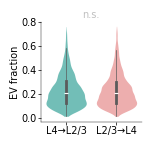

In [16]:
plot_directionalities(dir_mouse_df_stimulus, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction', linewidth=0)

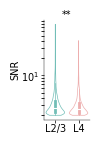

In [17]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

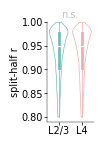

In [18]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

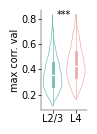

In [19]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95)



#### plot supplemental material

In [138]:
### get normal ridge regression evars (just like in figure 2)

from neuron_properties_functions import get_evars_all_mice

get_evars_all_mice(main_dir, mouse_stats, activity_type='resp')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp', control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)

mouse_df_all = make_mouse_df(mouse_stats)
mouse_df=mouse_df_all[(mouse_df_all['SNR']>2) & (mouse_df_all['Split-half r']>0.8)]


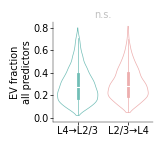

In [28]:
plot_directionalities(mouse_df, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False)

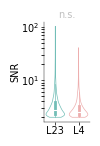

In [ ]:
plot_directionalities(mouse_df, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

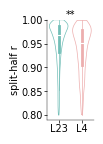

In [142]:
plot_directionalities(mouse_df, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

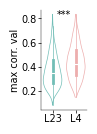

In [143]:
plot_directionalities(mouse_df, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95)



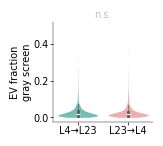

In [149]:
dir_mouse_df_gray_screen = make_mouse_df_directionality(mouse_stats_=mouse_stats, dataset_types=['ori32_spont','natimg32_spont'])

plot_directionalities(dir_mouse_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0)


## Macaque Directionality

In [164]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)

In [ ]:
store_V1_indices(monkey_stats)
get_directionality_evars_monkey(monkey_stats, control_shuffle=False)
get_directionality_evars_monkey(monkey_stats, control_shuffle=True)

### plotting

In [29]:
dir_monkey_df_stimulus = make_monkey_df_directionality(monkey_stats)


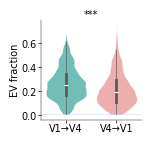

In [30]:
plot_directionalities(dir_monkey_df_stimulus, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction', linewidth=0, animal='monkey')

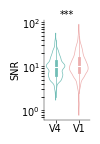

In [206]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False,animal='monkey')

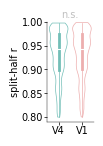

In [207]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

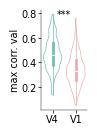

In [208]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

#### supplemental

In [ ]:
from neuron_properties_functions import get_evar_monkey_all_dates

get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)

In [31]:
df_monkey_all = make_monkey_df(monkey_stats, dataset_types=['SNR', 'RF_thin', 'RF_large'])
df_monkey = df_monkey_all[df_monkey_all['Split-half r']>0.8]


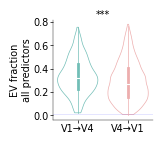

In [32]:
plot_directionalities(df_monkey, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False,animal='monkey')

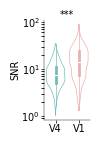

In [213]:
plot_directionalities(df_monkey, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False,animal='monkey')

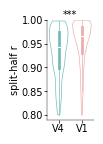

In [214]:
plot_directionalities(df_monkey, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

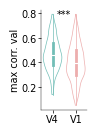

In [215]:
plot_directionalities(df_monkey, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

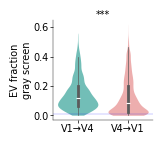

In [33]:
dir_monkey_df_gray_screen = make_monkey_df_directionality(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])

plot_directionalities(dir_monkey_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0,animal='monkey')

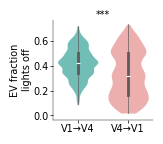

In [27]:
dir_monkey_df_lights_off = make_monkey_df_directionality(monkey_stats, dataset_types=['RS'])
plot_directionalities(dir_monkey_df_lights_off, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nlights off', linewidth=0,animal='monkey')